In [5]:
import torchvision.transforms as tt
from torch.utils.data import random_split
import numpy as np
from torchvision.datasets import ImageFolder
import os
data_dir = 'd:/Effusion_T/val'
os.listdir(data_dir) # ['Effusion', 'Normal']
train_ds = ImageFolder(data_dir, tt.Compose([tt.Resize([64,64]), tt.RandomInvert(0.5) ,tt.ToTensor()]))

val_pct = 0.1
val_size = int(val_pct * len(train_ds))
train_size = len(train_ds) - val_size



train_ds, valid_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(valid_ds)

(5268, 585)

In [6]:
import torch
import torch.nn.functional as F

In [7]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

In [8]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

Effusion : 3827
Normal : 2027


In [9]:
def get_default_device():
    if torch.cuda.is_available(): # Pick GPU if available, else CPU
        return torch.device('cuda')
    else:
        return torch.device('GPU')
    
def to_device(data, device):
    # Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)): 
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batches
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
# moves data to GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [13]:
# extending the nn.Module class
class ImageClassificationBase(nn.Module):
  def training_step(self, batch): # calculating loss for a batch of training data
    images, labels = batch
    out = self(images) # Pass images into the model and generates predictions
    loss = F.cross_entropy(out, labels) # Calculate loss using cross entropy
    return loss

  def validation_step(self, batch): # calculating loss and accuracy for a batch of validation data
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels) # Calculate loss using cross entropy
    acc = accuracy(out, labels) # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() # Combine losses and take the mean
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies and take the mean
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()} # Combine all results for the validation set

  def epoch_end(self, epoch, result): # will print all the information after each epoch
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
def accuracy(outputs, labels): # calculates accuracy of the predictions
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
@torch.no_grad() # tells pytorch to not compute gradients while in evaluation mode
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch) # takes a batch of data from the training set and returns the loss for that batch
            train_losses.append(loss)
            loss.backward() # calculates gradients
            optimizer.step() # performs gradient descent and update the weights of the model
            optimizer.zero_grad() # clears out gradients
        # Validation phase
        result = evaluate(model, val_loader) # go into evaluation mode
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
from torch.nn.modules.pooling import MaxPool2d

def conv_block(in_channels, out_channels, pool=False):
  # BatchNorm2d for regularization and reduce overfitting
        # applying activation function (ReLU) and introducing non-linearity
        # MaxPool2d takes each set of 4 pixels and replaces them with the max value
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ChestXrayModel_1(ImageClassificationBase): # extending ImageClassificationBase
    def __init__(self, in_channels, num_classes):
        super().__init__()
        

        # Input: 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 32) 
        self.conv2 = conv_block(32, 64, pool=True) # 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(64, 64), # 128 x 32 x 32
                                  conv_block(64, 64)) 
        
        self.conv3 = conv_block(64, 128, pool=True) # 256 x 16 x 16
        self.conv4 = conv_block(128, 256, pool=True) # 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(256, 256),  # 512 x 8 x 8
                                  conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 512 x 1 x 1 
                                        nn.Flatten(), # 512 x 1; flattens the output feature map into a vector
                                        nn.Dropout(0.2),
                                        nn.Linear(256, num_classes))
        
        
    def forward(self, xb): # taking the input and adding it back to the output throughout the layers
        out = self.conv1(xb)
        out = self.conv2(out) # ouput becomes an input. 
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [16]:
model = to_device(ChestXrayModel_1(3, 2), device)
model

ChestXrayModel_1(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=T

In [17]:
import torch
import h5py

# Load the model parameters from the H5 file
model_h5 = h5py.File('C:/Users/tjoeun/Desktop/P3H5/Effusion/model.h5', 'r')
state_dict = {}
for key in model_h5.keys():
    state_dict[key] = torch.Tensor(model_h5[key][()])

model_h5.close()

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Move the loaded model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [22]:
test_dataset = ImageFolder('d:/Effusion_T/val', tt.ToTensor())

In [24]:
def predict_image(img, model, classes): # number of classes is 2: NORMAL and PNEUMONIA
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [25]:
import matplotlib.pyplot as plt

In [58]:
import torch
import torch.nn.functional as F
a = 102
# Input tensor
input_tensor = test_dataset[a][0]  # Accessing the tensor part of test_dataset[2]
input_answer = test_dataset[a][1]
#Desired output size
if input_tensor.shape[1] >=496 and input_tensor.shape[1]<=992 and input_tensor.shape[2] >=496 and input_tensor.shape[2]<=992:
    x = input_tensor.shape[1]
    y = input_tensor.shape[2]
else:
    x = int(input_tensor.shape[1]/2)
    y = int(input_tensor.shape[2]/2)


output_size = (x,y)

# Resize the tensor
resized_tensor = F.interpolate(input_tensor.unsqueeze(0), size=output_size, mode='bilinear', align_corners=False)

# Remove the batch dimension
resized_tensor = resized_tensor.squeeze(0)

Target: Effusion , Predicted: Normal


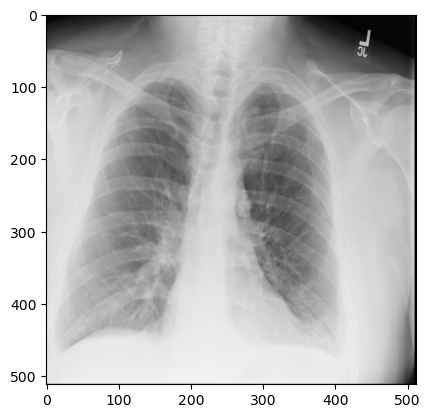

In [76]:
torch.cuda.empty_cache()
img= resized_tensor
label = input_answer
plt.imshow(img.permute(1, 2, 0))
pred = predict_image(img, model, train_ds.dataset.classes)
print('Target:', train_ds.dataset.classes[label], ', Predicted:', pred)